The project attempts a partial implementation of the Deep Learning for Symbolic Mathematics paper (2019) from Facebook research.

# Notebook overview:
This notebook has the following main steps for model training and testing (1-6):

    ** Training **
    1. Initialize the SymbolicModelTrain class and load the integration data
    In step 1, SymbolicModelTrain class alows the user to run model experiments with different sets of model hyperparameters of their choice.
    
    2. Create the TensorFlow processors to tokenize the input and output data
    3. Prepare the training data (fed in batch as an iterator)
    4. Run the model experiments on different hyperparameters
    
    ** Testing **
    5. Plot the model result to pick the best model and save it
    6. Fit the test data to check the model performance

The training phase (1 through 4) can be run with the run_all() function, but the functions are called individually in this notebook for the purpose of explaining the steps one by one.

Note: I referred to the Tensorflow's seq2seq model tutorial to define some text processing functions. Those functions have explicit reference in the .py script, with the line "source: tensorflow seq2seq tutorial". The link to the tutorial: https://www.tensorflow.org/text/tutorials/nmt_with_attention

### Importing libraries and installing dependencies

In [1]:
## Colab specific code: To be able to run this notebook in the user's environment, redefine the sys path
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/project_folder')
sys.path.append('/content/drive/My Drive/Colab Notebooks/project_folder/data')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import tensorflow as tf
tf.__version__

'2.9.2'

In [3]:
from run_model_train import SymbolicModelTrain

## Step 1. load the data

    Load the training and validation data. Training data has ~20M rows, validation ~10,000 rows

In [4]:
IntegrationModel = SymbolicModelTrain()

In [5]:
IntegrationModel.load_data(data_path="/content/drive/My Drive/Colab Notebooks/project_folder/data")

X_train rows:  19828463
y_train rows:  19828463
X_valid rows:  9985
y_valid rows:  9985


In [6]:
for input_expression, output_expression in IntegrationModel.train_intermed.take(1):
    print(input_expression[0:10])
    print(output_expression[0:10])
    break

tf.Tensor(
[b"sub Y' x" b"sub Y' mul INT+ 2 x" b"sub Y' mul INT+ 2 pow x INT+ 2"
 b"sub Y' add pow x INT+ 2 mul INT+ 2 x" b"sub Y' mul INT+ 2 pow x INT+ 3"
 b"sub Y' mul INT+ 4 pow x INT+ 2" b"sub Y' add x mul INT+ 2 pow x INT+ 2"
 b"sub Y' mul INT+ 3 pow x INT+ 2" b"sub Y' mul x add x pow x INT+ 2"
 b"sub Y' sqrt x"], shape=(10,), dtype=string)
tf.Tensor(
[b'mul div INT+ 1 INT+ 2 pow x INT+ 2' b'pow x INT+ 2'
 b'mul div INT+ 2 INT+ 3 pow x INT+ 3'
 b'add pow x INT+ 2 mul div INT+ 1 INT+ 3 pow x INT+ 3'
 b'mul div INT+ 1 INT+ 2 pow x INT+ 4'
 b'mul div INT+ 4 INT+ 3 pow x INT+ 3'
 b'add mul div INT+ 1 INT+ 2 pow x INT+ 2 mul div INT+ 2 INT+ 3 pow x INT+ 3'
 b'pow x INT+ 3'
 b'add mul div INT+ 1 INT+ 3 pow x INT+ 3 mul div INT+ 1 INT+ 4 pow x INT+ 4'
 b'mul div INT+ 2 INT+ 3 pow x div INT+ 3 INT+ 2'], shape=(10,), dtype=string)



#### Note about the input and output data

Notice that the input and output data for symbolic mathematical expressions can be reconstructed to a tree structure where nodes are the operators (sub for subtraction, mul for multiplication, pow for power and so on). It follows the prefix notation to read the tree from left to right and write each node before its children.

For example, the input expression "sub Y' x" translates to Y'-x = 0, which is equivalent to Y' = x.

Integrating the above returns "mul div INT+ 1 INT+ 2 pow x INT+ 2", which translates to "multipy [(divide 1 by 2) and (x to the power of 2)]", which is 1/2(x^2), a correct solution solving for Y.

## Step 2. Set the context and target processor

    Given the input and output sequences, context and target processors extract vocabularies, clean the sequences, and convert them into tokenized forms. Using the vocabularies defined, the tokenized sequences can be recovered to the original form (see examples below)
    

##### Important note

Standardizing the input and output data should still contain essential information. For example, the plus sign in the "INT+" should be kept to differentiate whether an integer digit is positive or negative, so the data cleaning should not treat the plus sign as an unnecessary special character and replace it. For details of how the cleaning is done, refer to \__process_text__ method in run_model_train.py

In [7]:
IntegrationModel.set_processor()

In [8]:
# vocabularies in the input expression
print(len(IntegrationModel.context_processor.get_vocabulary()))
print(IntegrationModel.context_processor.get_vocabulary()[:10])

45
['', '[UNK]', 'int+', 'x', 'mul', 'add', '2', '1', 'pow', 'int-']


In [9]:
# given the input sequence, context_processor converts it to a set of tokens
print(f"input sequence: {input_expression[0]}")
input_tokenized=IntegrationModel.context_processor(input_expression[0])
print(input_tokenized)
print("")

# notice that the input_tokenized is longer than the original lenght because of the [START] and [END] token added
input_vocabs = np.array(IntegrationModel.context_processor.get_vocabulary())
' '.join(input_vocabs[input_tokenized.numpy()])

input sequence: b"sub Y' x"
tf.Tensor([10 13 12  3 11], shape=(5,), dtype=int64)



"[START] sub y' x [END]"

In [10]:
# vocabularies in the target expression
print(len(IntegrationModel.target_processor.get_vocabulary()))
IntegrationModel.target_processor.get_vocabulary()[:10]

41


['', '[UNK]', 'int+', 'mul', 'x', 'add', '2', '1', 'pow', 'div']

In [11]:
# given the taregt sequence, target_processor converts it to a set of tokens
print(f"output sequence: {output_expression[0]}")
output_tokenized=IntegrationModel.target_processor(output_expression[0])
print(output_tokenized)
print("")

# notice that the input_tokenized is longer than the original lenght because of the [START] and [END] token added
output_vocabs = np.array(IntegrationModel.target_processor.get_vocabulary())
' '.join(output_vocabs[output_tokenized.numpy()])

output sequence: b'mul div INT+ 1 INT+ 2 pow x INT+ 2'
tf.Tensor([14  3  9  2  7  2  6  8  4  2  6 15], shape=(12,), dtype=int64)



'[START] mul div int+ 1 int+ 2 pow x int+ 2 [END]'

## Step 3. set train datasets

    At this step, set the train datasets for model.fit() method by converting the input into "(context_input, target_input), target_output" format.

In [12]:
IntegrationModel.set_train_datasets()

In [13]:
# notice the target output is shifted to the left by one from the target input
for (context_input, tar_input), tar_output in IntegrationModel.train_ds.take(1):
    print(context_input[0, :10].numpy()) 
    print()
    print(tar_input[0, :10].numpy()) 
    print(tar_output[0, :10].numpy())

[10 13 12  3 11  0  0  0  0  0]

[14  3  9  2  7  2  6  8  4  2]
[3 9 2 7 2 6 8 4 2 6]


## Step 4. Run model experiments

In [14]:
IntegrationModel.train_model()

Initializing trial_1...
Initializing trial_1:
                    - units: 64
                    - optimizer: adam
                    - epoch: 100
                    - is_gru: True
                    - num_heads: 4
                    

Epoch 1/100
100/100 [==============================] - 21s 64ms/step - loss: 0.6176 - accuracy: 0.3996 - masked_loss: 2.1713 - val_loss: 0.3624 - val_accuracy: 0.4812 - val_masked_loss: 1.9746
Epoch 2/100
100/100 [==============================] - 3s 31ms/step - loss: 0.4198 - accuracy: 0.5381 - masked_loss: 1.9699 - val_loss: 0.3586 - val_accuracy: 0.5345 - val_masked_loss: 1.9563
Epoch 3/100
100/100 [==============================] - 3s 29ms/step - loss: 0.4912 - accuracy: 0.5687 - masked_loss: 1.9768 - val_loss: 0.3567 - val_accuracy: 0.5508 - val_masked_loss: 1.9473
Epoch 4/100
100/100 [==============================] - 3s 30ms/step - loss: 0.4691 - accuracy: 0.5695 - masked_loss: 1.9669 - val_loss: 0.3556 - val_accuracy: 0.5591 - val_masked_los

## Step 5. Evaluate model performance

In [15]:
# model summary

for t in IntegrationModel.training_result.keys():
    print(t)
    print(IntegrationModel.training_result[t]['trained_model'].summary())
    print("")

trial_1
Model: "symbolic_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  52800     
                                                                 
 decoder (Decoder)           multiple                  96745     
                                                                 
Total params: 149,545
Trainable params: 149,545
Non-trainable params: 0
_________________________________________________________________
None

trial_2
Model: "symbolic_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  68928     
                                                                 
 decoder_1 (Decoder)         multiple                  96745     
                                                                

In [50]:
# model summary

for t in IntegrationModel.training_result.keys():
    print(t)
    print("total epoch run: ", len(IntegrationModel.training_result[t]['history'].history['accuracy']))
    
    print("average accuracy across all epoch: ", np.mean(IntegrationModel.training_result[t]['history'].history['accuracy']))
    print("final accuracy: ", IntegrationModel.training_result[t]['history'].history['accuracy'][-1])

    print("average loss across all epoch: ", np.mean(IntegrationModel.training_result[t]['history'].history['loss']))
    print("final loss across all epoch: ", IntegrationModel.training_result[t]['history'].history['loss'][-1])

    print("")

trial_1
total epoch run:  91
average accuracy across all epoch:  0.6806479152087327
final accuracy:  0.7467483878135681
average loss across all epoch:  0.38201323937583753
final loss across all epoch:  0.3396768569946289

trial_2
total epoch run:  100
average accuracy across all epoch:  0.6890698257088661
final accuracy:  0.7516358494758606
average loss across all epoch:  0.3800591516494751
final loss across all epoch:  0.3785402774810791

trial_3
total epoch run:  85
average accuracy across all epoch:  0.7245678956017775
final accuracy:  0.8041403293609619
average loss across all epoch:  0.38076223415486954
final loss across all epoch:  0.36188533902168274

trial_4
total epoch run:  54
average accuracy across all epoch:  0.7026895119084252
final accuracy:  0.7830737233161926
average loss across all epoch:  0.3915796920105263
final loss across all epoch:  0.3534772992134094

trial_5
total epoch run:  68
average accuracy across all epoch:  0.7339097419205833
final accuracy:  0.804540932

### 5.1 Accuracy vs Loss plots

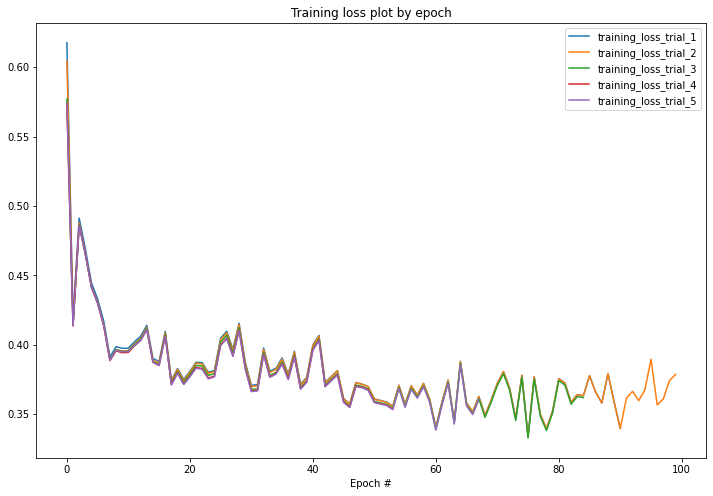

In [16]:
plt.subplots(figsize=(12,8))
for t in IntegrationModel.training_result.keys():
    history = IntegrationModel.training_result[t]['history']
    plt.plot(history.history['loss'], label=f'training_loss_{t}')
    plt.title("Training loss plot by epoch")
    plt.xlabel('Epoch #')
    plt.legend()

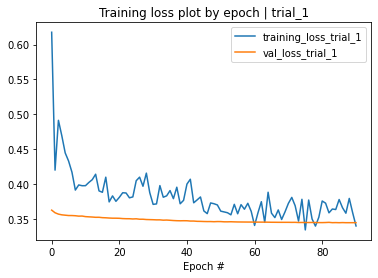

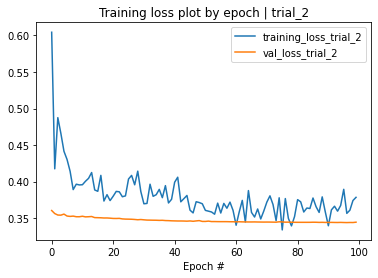

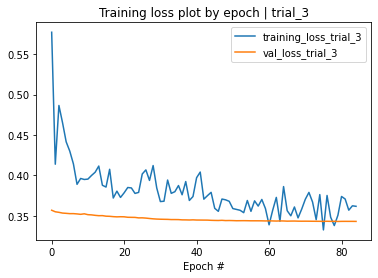

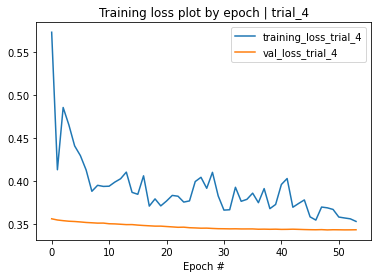

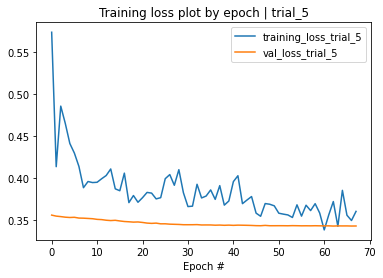

In [17]:
for t in IntegrationModel.training_result.keys():
    history = IntegrationModel.training_result[t]['history']
    plt.plot(history.history['loss'], label=f'training_loss_{t}')
    plt.plot(history.history['val_loss'], label=f'val_loss_{t}')
    plt.title(f"Training loss plot by epoch | {t}")
    plt.xlabel('Epoch #')
    plt.legend()
    plt.show()

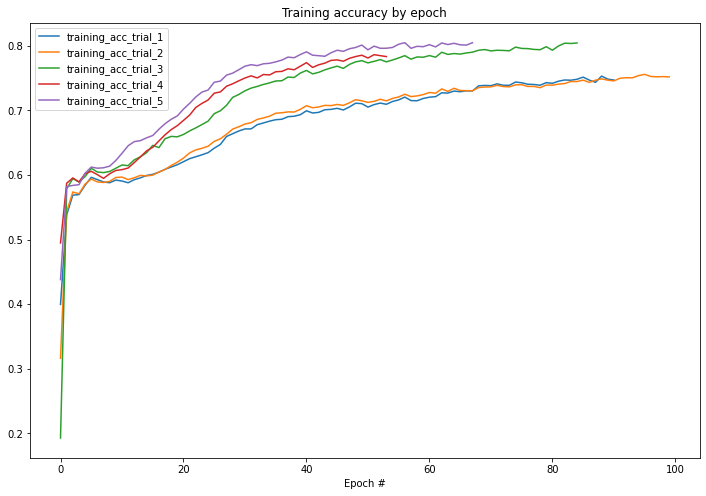

In [18]:
plt.subplots(figsize=(12,8))
for t in IntegrationModel.training_result.keys():
    history = IntegrationModel.training_result[t]['history']
    plt.plot(history.history['accuracy'], label=f'training_acc_{t}')
    plt.xlabel('Epoch #')
    plt.title("Training accuracy by epoch")
    plt.legend()

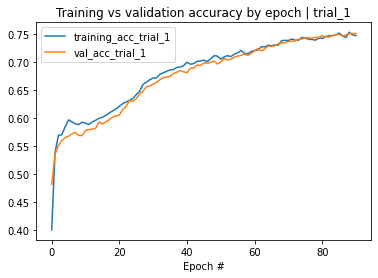

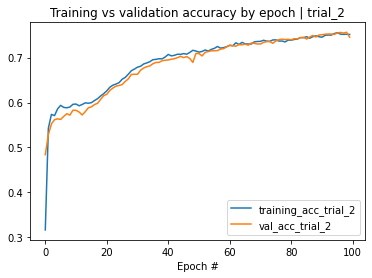

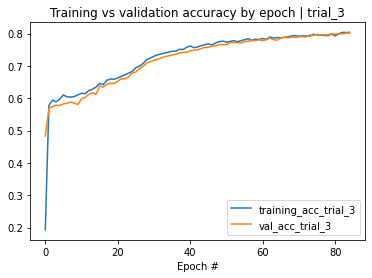

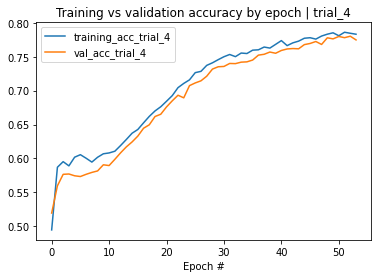

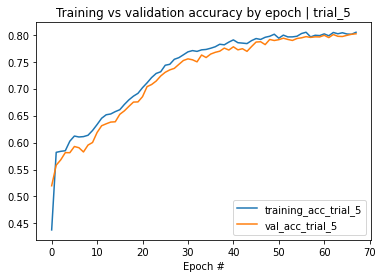

In [19]:
for t in IntegrationModel.training_result.keys():
    history = IntegrationModel.training_result[t]['history']

    plt.plot(history.history['accuracy'], label=f'training_acc_{t}')
    plt.plot(history.history['val_accuracy'], label=f'val_acc_{t}')
    plt.xlabel('Epoch #')
    plt.title(f"Training vs validation accuracy by epoch | {t}")
    plt.legend()
    plt.show()


### 5.2 Decoder translation for example sequence

In [20]:
input_expression[:10]

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b"sub Y' x", b"sub Y' mul INT+ 2 x",
       b"sub Y' mul INT+ 2 pow x INT+ 2",
       b"sub Y' add pow x INT+ 2 mul INT+ 2 x",
       b"sub Y' mul INT+ 2 pow x INT+ 3",
       b"sub Y' mul INT+ 4 pow x INT+ 2",
       b"sub Y' add x mul INT+ 2 pow x INT+ 2",
       b"sub Y' mul INT+ 3 pow x INT+ 2",
       b"sub Y' mul x add x pow x INT+ 2", b"sub Y' sqrt x"], dtype=object)>

In [22]:
output_expression[:10]

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'mul div INT+ 1 INT+ 2 pow x INT+ 2', b'pow x INT+ 2',
       b'mul div INT+ 2 INT+ 3 pow x INT+ 3',
       b'add pow x INT+ 2 mul div INT+ 1 INT+ 3 pow x INT+ 3',
       b'mul div INT+ 1 INT+ 2 pow x INT+ 4',
       b'mul div INT+ 4 INT+ 3 pow x INT+ 3',
       b'add mul div INT+ 1 INT+ 2 pow x INT+ 2 mul div INT+ 2 INT+ 3 pow x INT+ 3',
       b'pow x INT+ 3',
       b'add mul div INT+ 1 INT+ 3 pow x INT+ 3 mul div INT+ 1 INT+ 4 pow x INT+ 4',
       b'mul div INT+ 2 INT+ 3 pow x div INT+ 3 INT+ 2'], dtype=object)>

In [33]:
IntegrationModel.model_params

{'trial_1': {'epoch': 100,
  'optimizer': 'adam',
  'num_units': 64,
  'is_gru': True,
  'num_heads': 4},
 'trial_2': {'epoch': 100,
  'optimizer': 'RMSprop',
  'num_units': 64,
  'is_gru': False,
  'num_heads': 4},
 'trial_3': {'epoch': 100,
  'optimizer': 'adam',
  'num_units': 256,
  'is_gru': False,
  'num_heads': 8},
 'trial_4': {'epoch': 100,
  'optimizer': 'adam',
  'num_units': 256,
  'is_gru': True,
  'num_heads': 8},
 'trial_5': {'epoch': 100,
  'optimizer': 'adam',
  'num_units': 512,
  'is_gru': True,
  'num_heads': 8}}

In [32]:
# solve for y given y' = x
# correct solution is "mul div INT+ 1 INT+ 2 pow x INT+ 2", y = 1/2(x^2)

res1 = IntegrationModel.training_result['trial_1']['trained_model'].translate(["sub Y' x"]).numpy()
res2 = IntegrationModel.training_result['trial_2']['trained_model'].translate(["sub Y' x"]).numpy()
res3 = IntegrationModel.training_result['trial_3']['trained_model'].translate(["sub Y' x"]).numpy()
res4 = IntegrationModel.training_result['trial_4']['trained_model'].translate(["sub Y' x"]).numpy()
res5 = IntegrationModel.training_result['trial_5']['trained_model'].translate(["sub Y' x"]).numpy()

print(res1) # returns y = 1/2
print(res2) # returns illegal expression; similar to x*x^2
print(res3) # (CORRECT SOLUTION) returns y = 1/2*(x^2)
print(res4) # returned expression contains (1/2 * x^2), but repeats it many times
print(res5) # returns y = 1/2*(x^2*x^2)

tf.Tensor([b'[START]'], shape=(1,), dtype=string)
tf.Tensor([b'[START]'], shape=(1,), dtype=string)
tf.Tensor([b'[START]'], shape=(1,), dtype=string)
tf.Tensor([b'[START]'], shape=(1,), dtype=string)
tf.Tensor([b'[START]'], shape=(1,), dtype=string)
[b'div int+ 1 int+ 2 ']
[b'1 mul x pow x int+ 2 ']
[b'mul div int+ 1 int+ 2 pow x int+ 2 ']
[b'add mul div int+ 1 int+ 2 pow x int+ 2 add mul div int+ 1 int+ 2 pow x int+ 2 add mul div int+ 1 int+ 2 pow x int+ 2 mul div int+ 1 int+ 2 pow']
[b'mul div int+ 1 int+ 2 mul pow x int+ 2 pow x int+ 2 ']


In [34]:
# solve for y given y'= 2x
# correct solution is "pow x INT+ 2", y = x^2
res1 = IntegrationModel.training_result['trial_1']['trained_model'].translate(["sub Y' mul INT+ 2 x"]).numpy()
res2 = IntegrationModel.training_result['trial_2']['trained_model'].translate(["sub Y' mul INT+ 2 x"]).numpy()
res3 = IntegrationModel.training_result['trial_3']['trained_model'].translate(["sub Y' mul INT+ 2 x"]).numpy()
res4 = IntegrationModel.training_result['trial_4']['trained_model'].translate(["sub Y' mul INT+ 2 x"]).numpy()
res5 = IntegrationModel.training_result['trial_5']['trained_model'].translate(["sub Y' mul INT+ 2 x"]).numpy()

print(res1) # returns 2*x^2
print(res2) # returns 1/2*(x^2*x^2)
print(res3) # returns x^2*x^2
print(res4) # returns 1/2*x^2
print(res5) # returns 2*x^2

tf.Tensor([b'[START]'], shape=(1,), dtype=string)
tf.Tensor([b'[START]'], shape=(1,), dtype=string)
tf.Tensor([b'[START]'], shape=(1,), dtype=string)
tf.Tensor([b'[START]'], shape=(1,), dtype=string)
tf.Tensor([b'[START]'], shape=(1,), dtype=string)
[b'mul int+ 2 pow x int+ 2 ']
[b'mul div int+ 1 int+ 2 mul pow x int+ 2 pow x int+ 2 ']
[b'mul pow x int+ 2 pow x int+ 2 ']
[b'mul div int+ 1 int+ 2 pow x int+ 2 ']
[b'mul int+ 2 pow x int+ 2 ']


In [35]:
# solve for y given y'= 4x^3
# correct solution is "pow x INT+ 4", y=x^4

res1 = IntegrationModel.training_result['trial_1']['trained_model'].translate(["sub Y' mul INT+ 4 pow x INT+ 3"]).numpy()
res2 = IntegrationModel.training_result['trial_2']['trained_model'].translate(["sub Y' mul INT+ 4 pow x INT+ 3"]).numpy()
res3 = IntegrationModel.training_result['trial_3']['trained_model'].translate(["sub Y' mul INT+ 4 pow x INT+ 3"]).numpy()
res4 = IntegrationModel.training_result['trial_4']['trained_model'].translate(["sub Y' mul INT+ 4 pow x INT+ 3"]).numpy()
res5 = IntegrationModel.training_result['trial_5']['trained_model'].translate(["sub Y' mul INT+ 4 pow x INT+ 3"]).numpy()

print(res1) # returns 4x^2
print(res2) # returns 1/2*(x^2*x^2)
print(res3) # returns 1/2*(x^4)
print(res4) # returns 2*(x^4)
print(res5) # returns 2*(x^2)

tf.Tensor([b'[START]'], shape=(1,), dtype=string)
tf.Tensor([b'[START]'], shape=(1,), dtype=string)
tf.Tensor([b'[START]'], shape=(1,), dtype=string)
tf.Tensor([b'[START]'], shape=(1,), dtype=string)
tf.Tensor([b'[START]'], shape=(1,), dtype=string)
[b'mul int+ 4 pow x int+ 2 ']
[b'mul div int+ 1 int+ 2 mul pow x int+ 2 pow x int+ 2 ']
[b'mul div int+ 1 int+ 2 pow x int+ 4 ']
[b'mul int+ 2 pow x int+ 4 ']
[b'mul int+ 2 pow x int+ 2 ']


In [36]:
# solve for y given y'= x^(2/3) (sub Y' pow x div INT+ 2 INT+ 3)
# correct solution is "mul div INT+3 INT+5 pow x div INT+ 5 INT+ 3", y=(3/5)*x^(5/3)

res1 = IntegrationModel.training_result['trial_1']['trained_model'].translate(["sub Y' pow x div INT+ 2 INT+ 3"]).numpy()
res2 = IntegrationModel.training_result['trial_2']['trained_model'].translate(["sub Y' pow x div INT+ 2 INT+ 3"]).numpy()
res3 = IntegrationModel.training_result['trial_3']['trained_model'].translate(["sub Y' pow x div INT+ 2 INT+ 3"]).numpy()
res4 = IntegrationModel.training_result['trial_4']['trained_model'].translate(["sub Y' pow x div INT+ 2 INT+ 3"]).numpy()
res5 = IntegrationModel.training_result['trial_5']['trained_model'].translate(["sub Y' pow x div INT+ 2 INT+ 3"]).numpy()

print(res1) # returns illegal expression: 1/2 AND 1/2*[(3/2)*x^(3/2)] AND 3/2
print(res2) # returns 1/2*x*(x)^(1/2) = 1/2*x^(3/2)
print(res3) # returns illegal expression: similar to 1/2*x^(7/2)
print(res4) # returns illegal expression: similar to 1/2 x^(7/3)
print(res5) # returns illegal expression: similar to 1/2*x^(3/3)

tf.Tensor([b'[START]'], shape=(1,), dtype=string)
tf.Tensor([b'[START]'], shape=(1,), dtype=string)
tf.Tensor([b'[START]'], shape=(1,), dtype=string)
tf.Tensor([b'[START]'], shape=(1,), dtype=string)
tf.Tensor([b'[START]'], shape=(1,), dtype=string)
[b'div int+ 1 int+ 2 mul div int+ 1 int+ 2 mul pow x div int+ 3 int+ 2 div int+ 3 int+ 2 div int+ 3 int+ 2 ']
[b'mul div int+ 1 int+ 2 mul x sqrt x ']
[b'mul div int+ 1 int+ 2 4 pow x div int+ 7 int+ 2 ']
[b'7 mul div int+ 1 int+ 2 7 pow x div int+ 7 int+ 3 ']
[b'mul div int+ 1 int+ 2 4 pow x div int+ 3 int+ 3 ']


# Step 6. Save the best model

This step uses the Export module from tensorflow tutorial to be able to save the translate method when saving the model

In [29]:
from model import Export

In [42]:
input_sample = ["sub Y' pow x INT+ 2", "sub Y' add x pow x INT+ 3",
       "sub Y' ln x", "sub Y' add x ln x",
       "sub Y' pow x div INT+ 5 INT+ 2",
       "sub Y' mul INT+ 4 pow x INT- 1",
       "sub Y' mul INT+ 9 pow x INT+ 2",
       "sub Y' add x mul INT+ 5 pow x INT+ 2", "sub Y' ln pow x INT+ 3",
       "sub Y' mul x add x mul INT- 1 pow x INT+ 2"]

In [48]:
model_fin = IntegrationModel.training_result['trial_5']['trained_model']
export_obj = Export(model_fin)
_ = export_obj.translate(tf.constant(input_sample))

In [45]:
tf.saved_model.save(export_obj, f"/content/drive/My Drive/Colab Notebooks/project_folder/models/best_model",
                    signatures={'serving_default': export_obj.translate})

Tensor("ReduceJoin/ReduceJoin:0", shape=(None,), dtype=string)


In [46]:
# load the model back to check it worked
loaded_model = tf.saved_model.load("/content/drive/My Drive/Colab Notebooks/project_folder/models/best_model")

In [49]:
loaded_model.translate([input_sample[0]])

<tf.Tensor: shape=(1,), dtype=string, numpy=
array([b'mul div int+ 1 int+ 3 pow x int+ 3                              '],
      dtype=object)>